> ### **Implementation Summary**
>
> ---
>
> ### **1. Plant Model**
> The unknown plant is given by:  
> $$
> y_{k+1} = \frac{1.5 y_k y_{k-1}}{1 + y_k^2 + y_{k-1}^2} + 0.7 \sin\left(0.5(y_k + y_{k-1})\right)\cos\left(0.5(y_k + y_{k-1})\right) + 1.2 u_k
> $$
> Perturbed version:  
> $$
> y_{k+1} = \frac{1.5 y_k y_{k-1}}{1 + y_k^2 + y_{k-1}^2} + w \sin(y_k + y_{k-1}) + 1.2 u_k
> $$
> where $w$ is a disturbance term.
>
> ---
>
> ### **2. Neural Network Structure**
> - $\hat{f}(z)$:
>   - Inputs: $z = [y_k, y_{k-1}, u_{k-1}]$
>   - Architecture: $3 \to 7\,(\tanh) \to 7\,(\tanh) \to 1\,(\text{linear, no bias})$
>   - Weights initialized in $[-0.1, 0.1]$
>
> - $\hat{g}(z)$:
>   - In general, it has the same inputs as $\hat{f}(z)$, but in this problem based on the figure, it has only one input $u_k$.
>   - Architecture: $3 \to 7\,(\tanh) \to 7\,(\tanh) \to 1\$ with no bias term.
>   - Bias only with a value chosen randomly in $[-0.1, 0.1]$.
>
> ---
>
> ### **Pretraining Details**
> Here we pretrain a neural network for the plant in Eq. (43). Note that $\hat{f}$ does not have the bias but there is a bias term added to the output layer of $\hat{g}$.  
> The paper does not mention the initial conditions, but it says that the larger the initial set is, more restriction should be posed on the initial weights of the neural networks.  
> In general, initial conditions should belong to the compact set $B$.  
> I have read the paper on *SASTRY, S. S., and ISIDORI, A., 1989, Adaptive control of linearizable systems. IEEE Transactions on Automatic Control* to find out whether they have some specific initial conditions for this problem, but I didn't find anything with this regard.  
> I decided to choose the initial state $(-1.5, 0.8)^\top$ and the initial input as $0$.  
> I have also set the $u_k$ to be uniformly chosen in $[-1.7, 1.7]$.  
> We also set the learning rate to be $0.1$. The optimizer is chosen to be SGD.
>
> ---
>
> ### **3. Pretraining Phase**
> - **Objective**: Approximate $f(\cdot)$ and $g(\cdot)$  
> - **Inputs**: $u_k \sim \mathcal{U}[-1.7, 1.7]$  
> - **Loss function**:  
>   $$
>   J_k = \left(\hat{f}(z(k)) + \hat{g}(z(k)) u_k - y_{k+1}\right)^2
>   $$
> - **Optimizer**: SGD with learning rate $\mu = 0.1$  
> - **Steps**: 7,000 and 14,000 iterations
>
> ---
>
> ### **4. Regulation Phase**
> - **Control Law**:  
>   $$
>   u_k = -\frac{\hat{f}(z(k))}{\hat{g}(z(k))}
>   $$
> - **Weight Updates (normalized gradient descent)**:  
>   $$
>   \Theta(k+1) = \Theta(k) - \frac{\mu}{2r_k} \nabla_{\Theta(k)} J_k, \quad r_k = 1 + \|\nabla_{\Theta(k)} J_k\|^2
>   $$
>   where $\Theta = [w^\top, v^\top]^\top$
>
> ---
>
> ### **5. Analytic Controller**
> - **Model**:  
>   $$
>   y_{k+1} = a(k) \cdot \frac{1.5 y_k y_{k-1}}{1 + y_k^2 + y_{k-1}^2} + b(k) u_k
>   $$
> - **Updates**:
>   $$
>   \begin{aligned}
>   \text{Prediction error:} &\quad e = (a \cdot \text{term} + b u_k) - y_{k+1} \\
>   \text{Gradient descent:} &\quad a \leftarrow a - \mu \cdot e \cdot \text{term}, \quad b \leftarrow b - \mu \cdot e \cdot u_k
>   \end{aligned}
>   $$
>
> ---
>
> ### **6. Simulation Setup**
> - **Initial Conditions**:
>   - State: $y_{-1} = -1.5, \, y_0 = 0.8, \, u_{-1} = 0$
> - **Hyperparameters**:
>   - Learning rate: $\mu = 0.1$
>   - Pretraining steps: 14,000
>   - Regulation steps: 40


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

initial_state = (-1.5, 0.8, 0.0)

# Define the neural networks for f and g
class FNetwork(nn.Module):
    def __init__(self):
        super(FNetwork, self).__init__()
        self.fc1 = nn.Linear(3, 7, bias=False)
        self.fc2 = nn.Linear(7, 7, bias=False)
        self.out = nn.Linear(7, 1, bias=False)
        self.init_weights()

    def init_weights(self):
        for param in self.parameters():
            param.data.uniform_(-0.1, 0.1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return self.out(x)

class GNetwork(nn.Module):
    def __init__(self):
        super(GNetwork, self).__init__()
        self.out = nn.Linear(1, 1, bias=True)
        # Set weight to zero so only the bias is effective.
        self.out.weight.data.zero_()
        # Initialize the bias term uniformly.
        self.out.bias.data.uniform_(-0.1, 0.1)

    def forward(self, x):
        # The result will be independent of x because the weight is zero.
        return self.out(x)

# Plant models
def plant_part1(y_k, y_k_1, u_k):
    term1 = (1.5 * y_k * y_k_1) / (1 + y_k**2 + y_k_1**2)
    term2 = 0.7 * np.sin(0.5 * (y_k + y_k_1)) * np.cos(0.5 * (y_k + y_k_1))
    return term1 + term2 + 1.2 * u_k

def plant_part2(y_k, y_k_1, u_k, w):
    term1 = (1.5 * y_k * y_k_1) / (1 + y_k**2 + y_k_1**2)
    term2 = w * np.sin(y_k + y_k_1)
    return term1 + term2 + 1.2 * u_k

# Pretraining function
def pretrain(net_f, net_g, pretraining_steps=1000):
    y_current = initial_state[0]
    y_prev = initial_state[1]
    optimizer = torch.optim.SGD(list(net_f.parameters()) + list(net_g.parameters()), lr=0.1)
    for _ in range(pretraining_steps):
        u_k = np.random.uniform(-1.7, 1.7)
        y_next = plant_part1(y_current, y_prev, u_k)
        z = torch.tensor([y_current, y_prev, u_k], dtype=torch.float32)
        f_hat = net_f(z)
        if _ == 0:
            g_hat = torch.abs(net_g(torch.tensor([u_k], dtype=torch.float32)))
        else:
            g_hat = net_g(torch.tensor([u_k], dtype=torch.float32))
        y_pred = f_hat + g_hat * u_k
        loss = (y_pred - y_next)**2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_prev = y_current
        y_current = y_next
    return net_f, net_g

# Regulation with neural network
def regulate_nn_part1(net_f, net_g, initial_state, steps=40):
    y_current, y_prev, u_prev = initial_state
    outputs = [y_current]
    for _ in range(steps):
        z = torch.tensor([y_current, y_prev, u_prev], dtype=torch.float32)
        f_hat = net_f(z)
        if _ == 0:
            g_hat = torch.abs(net_g(torch.tensor([u_prev], dtype=torch.float32)))
        else:
            g_hat = net_g(torch.tensor([u_prev], dtype=torch.float32))
        u_k = (-f_hat / g_hat).item()
        y_next = plant_part1(y_current, y_prev, u_k)
        # Compute gradients
        net_f.zero_grad()
        net_g.zero_grad()
        f_hat.backward(retain_graph=True)
        g_hat.backward()
        grad_f = [p.grad.clone() for p in net_f.parameters()]
        grad_g = [p.grad.clone() * u_k for p in net_g.parameters()]
        combined_grad = grad_f + grad_g
        grad_norm = sum((g**2).sum() for g in combined_grad).sqrt().item()
        r_k = 1 + grad_norm**2
        mu = 1.0
        lr = mu / r_k
        # Update parameters
        with torch.no_grad():
            for p, g in zip(list(net_f.parameters()) + list(net_g.parameters()), combined_grad):
                p += lr * y_next * g
        u_prev = u_k
        y_prev = y_current
        y_current = y_next
        outputs.append(y_current)
    return outputs


# Regulation with neural network
def regulate_nn_part2(net_f, net_g, initial_state, steps=40, w=0):
    y_current, y_prev, u_prev = initial_state
    outputs = [y_current]
    for _ in range(steps):
        z = torch.tensor([y_current, y_prev, u_prev], dtype=torch.float32)
        f_hat = net_f(z)
        if _ == 0:
            g_hat = torch.abs(net_g(torch.tensor([u_prev], dtype=torch.float32)))
        else:
            g_hat = net_g(torch.tensor([u_prev], dtype=torch.float32))
        u_k = (-f_hat / g_hat).item()
        y_next = plant_part2(y_current, y_prev, u_k, w)
        # Compute gradients
        net_f.zero_grad()
        net_g.zero_grad()
        f_hat.backward(retain_graph=True)
        g_hat.backward()
        grad_f = [p.grad.clone() for p in net_f.parameters()]
        grad_g = [p.grad.clone() * u_k for p in net_g.parameters()]
        combined_grad = grad_f + grad_g
        grad_norm = sum((g**2).sum() for g in combined_grad).sqrt().item()
        r_k = 1 + grad_norm**2
        mu = 1.0
        lr = mu / r_k
        # Update parameters
        with torch.no_grad():
            for p, g in zip(list(net_f.parameters()) + list(net_g.parameters()), combined_grad):
                p += lr * y_next * g
        u_prev = u_k
        y_prev = y_current
        y_current = y_next
        outputs.append(y_current)
    return outputs


# Analytic controller for Part 2
class AnalyticController:
    def __init__(self):
        self.a = 1.0
        self.b = 1.2 

    def control(self, y_k, y_k_1):
        term = (1.5 * y_k * y_k_1) / (1 + y_k**2 + y_k_1**2)
        u_k = - (self.a * term) / self.b
        return u_k

    def update(self, y_k, y_k_1, u_k, y_next, lr=0.5):
        term = (1.5 * y_k * y_k_1) / (1 + y_k**2 + y_k_1**2)
        pred = self.a * term + self.b * u_k
        error = (pred - y_next)
        self.a -= lr * error * term
        self.b -= lr * error * u_k

# Regulation with analytic controller
def regulate_analytic(controller, initial_state, steps=40, w=0.0):
    y_current, y_prev, u_prev = initial_state
    outputs = [y_current]
    for _ in range(steps):
        u_k = controller.control(y_current, y_prev)
        y_next = plant_part2(y_current, y_prev, u_k, w)
        controller.update(y_current, y_prev, u_k, y_next)
        u_prev = u_k
        y_prev = y_current
        y_current = y_next
        outputs.append(y_current)
    return outputs


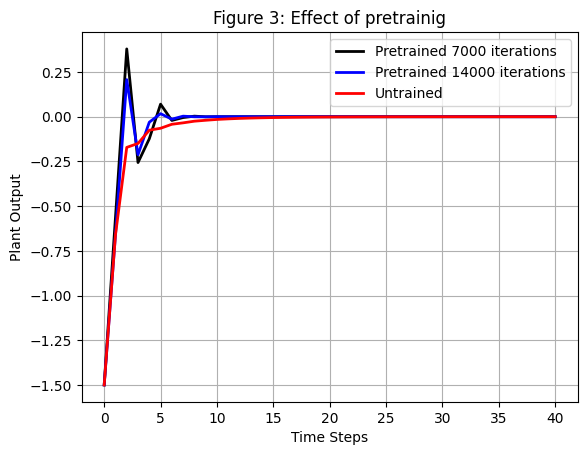

In [4]:

# Generate Figure 3: Pretraining effect
net_f_pretrained7000 = FNetwork()
net_g_pretrained7000 = GNetwork()
net_f_pretrained7000, net_g_pretrained7000 = pretrain(net_f_pretrained7000, net_g_pretrained7000, pretraining_steps=7000)

# Generate Figure 3: Pretraining effect
net_f_pretrained14000 = FNetwork()
net_g_pretrained14000 = GNetwork()
net_f_pretrained14000, net_g_pretrained14000 = pretrain(net_f_pretrained14000, net_g_pretrained14000, pretraining_steps=14000)

net_f_untrained = FNetwork()
net_g_untrained = GNetwork()


outputs_pretrained7000 = regulate_nn_part1(net_f_pretrained7000, net_g_pretrained7000, initial_state)
outputs_pretrained14000 = regulate_nn_part1(net_f_pretrained14000, net_g_pretrained14000, initial_state)
outputs_untrained = regulate_nn_part1(net_f_untrained, net_g_untrained, initial_state)

plt.figure()
plt.plot(outputs_pretrained7000, label='Pretrained 7000 iterations', color= 'black', linewidth = 2)
plt.plot(outputs_pretrained14000, label='Pretrained 14000 iterations', color= 'blue', linewidth = 2)
plt.plot(outputs_untrained, label='Untrained', color= 'red', linewidth = 2)
plt.xlabel('Time Steps')
plt.ylabel('Plant Output')
plt.title('Figure 3: Effect of pretrainig')
plt.legend()
plt.grid(True)
plt.show()


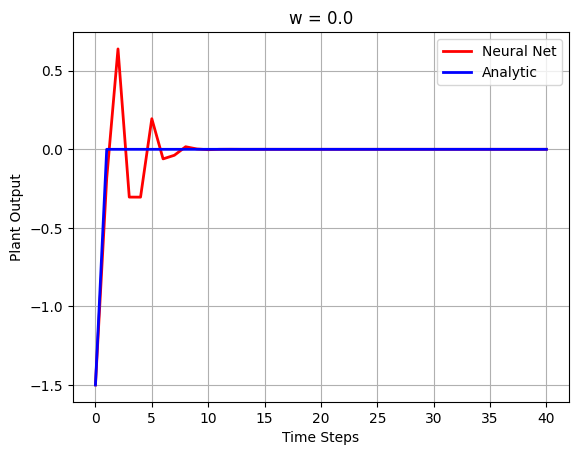

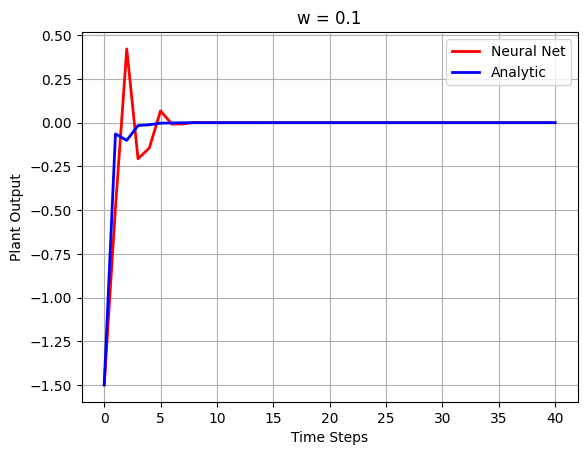

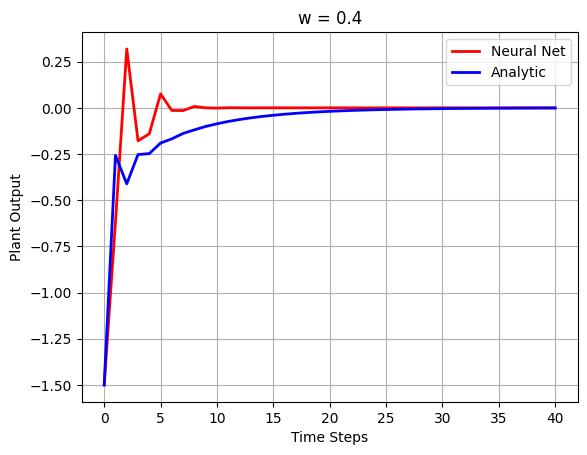

In [5]:
# Generate Figures 4-6: Comparison with analytic controller
def run_comparison(w):
    # Neural Net Control
    net_f = FNetwork()
    net_g = GNetwork()
    net_f, net_g = pretrain(net_f, net_g, pretraining_steps=14000)
    outputs_nn = regulate_nn_part2(net_f, net_g, initial_state, w=w)
    
    # Analytic Control
    controller = AnalyticController()
    outputs_analytic = regulate_analytic(controller, initial_state, w=w)
    
    plt.figure()
    plt.plot(outputs_nn, label='Neural Net', color= 'red', linewidth = 2)
    plt.plot(outputs_analytic, label='Analytic', color= 'blue', linewidth = 2)
    plt.xlabel('Time Steps')
    plt.ylabel('Plant Output')
    plt.title(f'w = {w}')
    plt.legend()
    plt.grid(True)

# Run for w=0, 0.1, 0.4
run_comparison(0.0)
run_comparison(0.1)
run_comparison(0.4)

plt.show()